## Projeto para Disciplina de Mineração de Dados  
## Aplicação de Técnica de classificação para Solução de Captcha  Sonoro
### Programa de Pós Graduação em Computação UFABC - 2º Quadrimestre de 2018



#### Integrantes:
Erick Fernandes da Cruz <br>
Gustavo Borges Lugoboni <br>
Igor Esteves de Oliveira 

## Código Desenvolvido

A seguir se encontram as bibliotecas que foram utilizadas para o desenvolvimento do presente projeto necessárias

In [1]:
#Bibliotecas utilizadas

import os
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import IPython.display as ipd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import tree

A primeira etapa que desenvolvemos foi a separação das letras que eram obtidas em cada audio que continha 4 caracteres, para isso utilizamos 2 arrays inicialmente, um deles contendo a onda especifica de cada letra do conjunto de treinamento e o outro com a letra correspondente

In [2]:
ArrayLetras = list()
Y = list()

A função a seguir normaliza os dados dos array entre -1 e 1, fazendo com que os diferentes volumes dos audios não interfiram nos calculos dos atributos

In [3]:
def normalizar(data) :
    
    #Definir valor máximo
    maximo = 0;
    if (max(data) > np.absolute(min(data))):
        maximo = max(data)
    else: 
        maximo = np.absolute(min(data))
    
    #Normalizar vetor entre -1 e 1
    x = 0
    while(x < len(data)):
        data[x] = data[x]/maximo
        x += 1
    
    return data

Para separar as letras desenvolvemos a função separar_letras que tem como objetivo receber um audio com 4 letras, dividir em 4 audios menores e a partir desses audios menores eliminar a maior parte do ruído possível através de uma frequência de corte para ter uma melhor representação de cada letra

In [4]:
def separar_letras(data, fs, destination_array) :

    #Separar em 4 conjuntos 
    n = 4
    splited = []
    len_l = len(data)
    for i in range(n):
        start = int(i*len_l/n)
        end = int((i+1)*len_l/n)
        splited.append(data[start:end])
    
    frame_lenght = 6300 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        if (initialBigger != 0):
            initialBigger = initialBigger - 1
    
        #Obter uma frequencia de corte baseada em um conjunto que possui apenas o ruído
        
        corte = 0
        if (initialBigger != 0):
            corte = max(frames_list[initialBigger - 1])
        else:     
            corte = max(frames_list[lastBigger + 2])
            
        value = np.hstack(frames_list[initialBigger:lastBigger+1])
        
        #Remover o ruído com base no corte obtido anteriormente
        variavel = 0
        while(variavel < len(value)):
            if value[variavel] < 0:
                if corte > np.absolute(value[variavel]):
                    value[variavel] = 0
                else: 
                    value[variavel] = value[variavel] + corte
            else: 
                if corte > value[variavel]:
                    value[variavel] = 0
                else:
                    value[variavel] = value[variavel] - corte
            
            variavel = variavel+1
        
        destination_array.append(normalizar(value))

Agora que tinhamos a função pronta criamos um laço que percorre todos os arquivos na pasta do conjunto de treinamento para que pudessemos recolher os dados para que estes fossem manipulados em um momento futuro

In [5]:
for root, dirs, files in os.walk("treino/"):  
    
    for filename in files:
        
        data, fs = librosa.load('treino/' + filename, None)
        for s in range(4):
            Y.append(filename[s])
            
        separar_letras(data, fs, ArrayLetras)

print(len(ArrayLetras))


800


# A PARTIR DAQUI É TUDO TESTE

In [6]:
#extraindo informações
duration = np.array([len(x)/fs for x in ArrayLetras])

tempo_beat = [librosa.beat.beat_track(y=x, sr=fs) for x in ArrayLetras]
tempo = np.array([x[0] for x in tempo_beat])
beat_frame = np.array([x[1] for x in tempo_beat])

mean_percussive = np.array([librosa.effects.hpss(x)[1].mean() for x in ArrayLetras])

sftf = [librosa.stft(x) for x in ArrayLetras]
mean_freq = np.array([np.abs(x).mean() for x in sftf])

mean_centroid = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in ArrayLetras]

train_base = np.array(list(zip(tempo, mean_percussive, mean_freq, mean_centroid)))


In [7]:
#carregando base de testes
Array_test = list()
Y_test = list()
for root, dirs, files in os.walk("teste/"):  
    
    for filename in files:
        
        data, fs = librosa.load('teste/' + filename, None)
        for s in range(4):
            Y_test.append(filename[s])
            
        separar_letras(data, fs, Array_test)


In [8]:
#extraindo informações
duration_test = np.array([len(x)/fs for x in Array_test])

tempo_beat_test = [librosa.beat.beat_track(y=x, sr=fs) for x in Array_test]
tempo_test = np.array([x[0] for x in tempo_beat_test])
beat_frame_test = np.array([x[1] for x in tempo_beat_test])

mean_percussive_test = np.array([librosa.effects.hpss(x)[1].mean() for x in Array_test])

sftf_test = [librosa.stft(x) for x in Array_test]
mean_freq_test = np.array([np.abs(x).mean() for x in sftf_test])

mean_centroid_test = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in Array_test]

test_base = np.array(list(zip(tempo_test, mean_percussive_test, mean_freq_test, mean_centroid_test)))

In [9]:
print(Array_test[0])

[0. 0. 0. ... 0. 0. 0.]


Gaussian Naive-Bayes

In [10]:
gnb = GaussianNB()
gnb.fit(train_base, Y)

GaussianNB()

In [11]:
false = 0
true = 0
for x in range(0, len(test_base)):
    if gnb.predict([test_base[x]])[0] == Y_test[x]:
        true += 1
    else:
        false += 1
print(true)
print(false)
        

231
561


Discriminante Linear

In [12]:
clf = LinearDiscriminantAnalysis()
clf.fit(train_base, Y)

/usr/lib/python3/dist-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [13]:
false = 0
true = 0
for x in range(0, len(test_base)):
    if clf.predict([test_base[x]])[0] == Y_test[x]:
        true += 1
    else:
        false += 1
print(true)
print(false)

198
594


KNN

In [14]:
norm_train = preprocessing.normalize(train_base, norm='l1')
norm_test = preprocessing.normalize(test_base, norm='l1')
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(norm_train, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
zfalse = 0
true = 0
for x in range(0, len(test_base)):
    if neigh.predict([norm_test[x]])[0] == Y_test[x]:
        true += 1
    else:
        false += 1
print(true)
print(false)

150
1236


Decision Tree

In [16]:
dtr = tree.DecisionTreeClassifier()
dtr = dtr.fit(train_base, Y)

In [17]:
false = 0
true = 0
x = 0
while x < len(test_base):
    
    teste = 0
    
    if dtr.predict([test_base[x]])[0] == Y[x]:
        teste += 1
    
    x += 1
    
    if dtr.predict([test_base[x]])[0] == Y[x]:
        teste += 1
    
    x += 1
    
    if dtr.predict([test_base[x]])[0] == Y[x]:
        teste += 1
    
    x += 1
    
    if dtr.predict([test_base[x]])[0] == Y[x]:
        teste += 1
        
    if teste == 4:
        true += 1
    else:
        false += 1
    x += 1
        
print(true)
print(false)

0
198


In [18]:
print (Y)

['6', '6', 'c', 'c', '6', '7', 'b', 'm', 'n', 'x', 'h', '6', '7', 'd', 'n', 'c', 'n', '7', 'c', 'x', 'm', '6', 'c', 'c', 'x', 'a', 'x', 'd', 'c', 'c', 'd', 'b', 'h', 'h', '7', 'm', 'b', 'x', 'b', 'b', 'a', 'b', '7', 'x', 'a', '7', 'b', '6', 'a', 'b', 'a', '6', '7', 'a', 'm', 'h', 'x', 'n', '6', 'a', 'm', 'n', '7', 'x', 'b', 'h', 'c', 'c', '6', 'n', 'x', 'x', 'a', 'm', '6', 'b', '6', '6', 'c', 'b', 'b', 'm', 'd', '7', '7', 'b', 'm', 'a', 'x', '7', 'h', '7', 'd', 'x', 'd', 'b', 'a', '6', 'd', 'h', 'h', 'b', '6', 'c', 'm', '7', '7', 'x', 'c', 'x', 'a', 'd', 'n', 'h', 'm', 'x', '6', '7', 'a', 'a', 'x', '7', 'a', 'c', 'c', 'b', 'x', '7', '6', 'a', 'd', '6', 'h', '7', 'h', 'h', 'x', 'n', 'c', 'n', '7', 'n', 'a', 'a', 'b', 'x', '7', '6', '6', 'c', '6', 'c', '7', 'n', 'c', 'h', '7', 'b', 'x', 'b', 'x', '7', 'c', 'c', '7', 'h', 'n', 'c', 'h', 'm', 'a', 'h', 'n', 'x', 'd', 'b', 'n', 'a', 'x', 'x', 'a', 'a', 'm', 'd', 'h', 'd', 'n', 'h', 'n', 'd', '6', 'b', 'c', 'a', 'a', 'c', 'c', 'x', 'h', 'n',

In [19]:
print (mean_percussive_test)

[-5.00236813e-04 -6.31996256e-04  3.33059666e-04  2.18730784e-04
  2.80194945e-04 -3.34236235e-03 -2.69768818e-04 -7.06011706e-05
  2.77468294e-04 -1.23226433e-04  7.63838616e-05  2.93470424e-04
  3.80172540e-04 -1.25693434e-04  1.19762597e-04  9.75205476e-05
  4.75489069e-04 -1.00717552e-04 -1.62241064e-04  1.50887834e-04
 -4.92776744e-04 -1.58765563e-03  1.35533593e-03 -1.62032340e-03
  1.27606399e-04  6.54459727e-05 -6.55972544e-05 -1.70789077e-04
  5.16932305e-05 -8.38999549e-05  5.08937403e-04 -9.76432522e-04
  4.45587561e-04 -8.23394570e-04 -5.41673857e-04  3.10412088e-06
 -5.17304252e-05 -1.53243274e-03 -7.31984386e-04 -1.80375398e-04
  1.39034510e-05 -2.46461341e-03 -7.87104582e-05 -7.99332556e-05
 -2.98956904e-04 -7.20792334e-04 -2.18671840e-03 -2.54830775e-05
 -3.54919839e-03  1.84579680e-04 -6.08144794e-04  2.05079748e-04
  3.03888111e-04 -6.98421965e-04 -7.69699342e-04  2.09996128e-03
  1.35573486e-04 -4.22990524e-05  8.85719061e-03 -2.13225069e-03
  2.40126019e-03 -1.74056

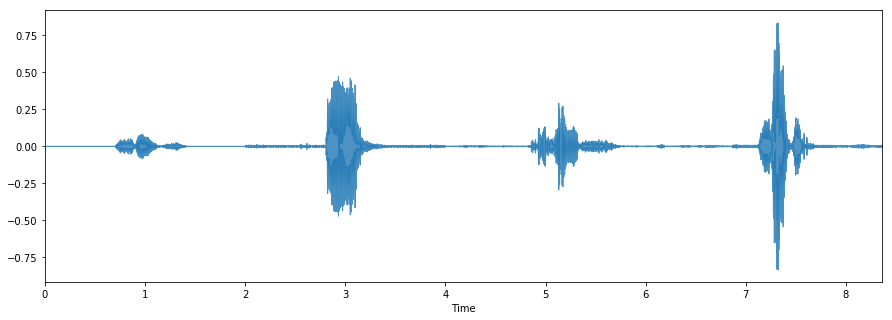

In [20]:
data, fs = librosa.load('treino/6a67.wav', None)
ipd.Audio(data, rate=fs)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, fs, alpha=0.8)

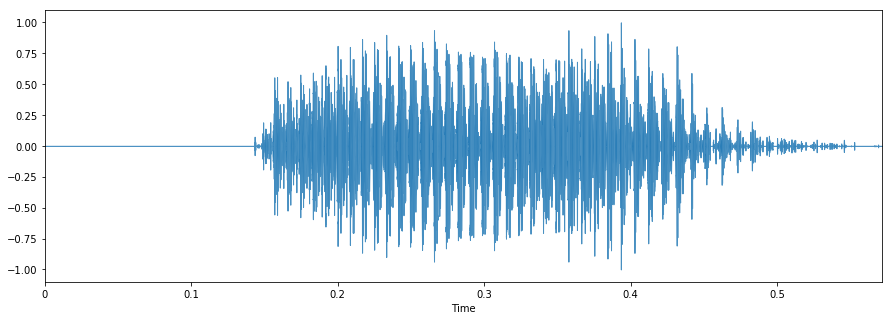

In [21]:
testando = list()
w = 0;
separar_letras(data, fs, testando)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(testando[1], fs, alpha=0.8)
ipd.Audio(testando[0], rate=fs)